In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

# Import the h5_analysis module containing all core functions
from h5_analysis import (
    discover_h5_files,
    read_h5_file,
    process_uv_vis_data,
    process_pl_data,
    wavelength_to_energy,
    apply_jacobian,
)

In [4]:
# Data directory configuration
data_dirs = [
    r"G:\My Drive\LPS\20250721_S_MeOMBAI_prestudy_3\CBox"
    # r"G:\Shared drives\SpinBot\20250724_swap_spec"
]

# Discover H5 files
h5_files = discover_h5_files(data_dirs)

# print(f"Found {len(h5_files)} H5 files:")
# for i, file in enumerate(h5_files[:5]):  # Show first 5
#     print(f"{i+1:>2}. {Path(file).name}")
# if len(h5_files) > 5:
#     print(f"... and {len(h5_files) - 5} more files")

Found 17 H5 files after filtering:

Ignored 1 files:
  - yrliu98_S-pMeMBAI-pre-3_1_18_run1_spec_run.h5: Lower run number (1) than yrliu98_S-pMeMBAI-pre-3_1_18_run2_spec_run.h5 (run 2)

 1. yrliu98_S-pMeMBAI-pre-3_1_10_run1_spec_run.h5
 2. yrliu98_S-pMeMBAI-pre-3_1_11_run1_spec_run.h5
 3. yrliu98_S-pMeMBAI-pre-3_1_12_run1_spec_run.h5
 4. yrliu98_S-pMeMBAI-pre-3_1_13_run1_spec_run.h5
 5. yrliu98_S-pMeMBAI-pre-3_1_14_run1_spec_run.h5
 6. yrliu98_S-pMeMBAI-pre-3_1_16_run1_spec_run.h5
 7. yrliu98_S-pMeMBAI-pre-3_1_17_run1_spec_run.h5
 8. yrliu98_S-pMeMBAI-pre-3_1_18_run2_spec_run.h5
 9. yrliu98_S-pMeMBAI-pre-3_1_1_run1_spec_run.h5
10. yrliu98_S-pMeMBAI-pre-3_1_2_run1_spec_run.h5
... and 7 more files


In [5]:
def get_label(metadata):
    """Extract a clean label from sample ID for plotting."""

    sample = int(metadata["sample_name"])
    result = None

    robot_dispenses = [80, 100, 130, 160, 190, 220]

    # If we successfully converted to int, this is a numeric sample ID
    if sample in [1, 2, 3]:
        result = f"GB-MBAI {sample}"
    elif sample in [4, 5, 6]:
        result = f"GB {sample - 3}"
    elif sample in [7, 8, 9]:
        result = f"Robot {sample - 6}"
    elif sample in [10, 11, 12]:
        result = f"Robot-MBAI {sample - 9}"
    elif sample in [13, 14, 15, 16, 17, 18]:
        result = f"Robot-dispense {robot_dispenses[sample - 13]:>3} uL/s"
    else:
        result = f"Sample {sample}"

    print(f"{metadata['sample_id']} -> {result}")
    return result

In [10]:
# Process H5 files and extract data for plotting
uv_vis_dfs = []
pl_dfs = []

# Process files (limit to first 10 for performance)
processed_files = []

for i, h5_file in enumerate(h5_files):
    # Read and process the H5 file
    print(f"Processing file {i + 1}/{len(h5_files)}: {Path(h5_file).name}")

    # Read the file
    data = read_h5_file(h5_file)
    if data is None:
        continue

    metadata = {
        **data["metadata"],
        "label": get_label(data["metadata"]),
    }

    metadata_df = pd.DataFrame({"metadata": [metadata]})

    # Process UV-Vis data
    uv_vis_results = process_uv_vis_data(data["wl_data"], (350, 700))

    # Process PL data
    pl_results = process_pl_data(data["pl_data"], (350, 700))

    # Create UV-Vis dataframe
    uv_vis_df = pd.DataFrame(
        {
            "wavelength": uv_vis_results["wavelength"],
            "energy": uv_vis_results["energy"],
            "absorption": uv_vis_results["absorption"],
            "absorption_jacobian": uv_vis_results["absorption_jacobian"],
            "transmission": uv_vis_results["transmission"],
        }
    )
    uv_vis_df = pd.concat([uv_vis_df, metadata_df], axis=1)
    uv_vis_dfs.append(uv_vis_df)

    # Create PL dataframe (use average spectrum if available)
    if pl_results["average_spectrum"] is not None:
        avg_spec = pl_results["average_spectrum"]
        pl_wavelength = avg_spec["wavelength"]
        pl_energy = wavelength_to_energy(pl_wavelength)
        pl_intensity_jacobian = apply_jacobian(avg_spec["intensity"], pl_wavelength)

        pl_df = pd.DataFrame(
            {
                "wavelength": pl_wavelength,
                "energy": pl_energy,
                "intensity": avg_spec["intensity"],
                "intensity_jacobian": pl_intensity_jacobian,
            }
        )
        pl_df = pd.concat([pl_df, metadata_df], axis=1)
        pl_dfs.append(pl_df)

    processed_files.append(data["metadata"]["sample_id"])


print(f"\nSuccessfully processed {len(processed_files)} files:")
for sample_id in processed_files:
    print(f"  - {sample_id}")

print(f"\nUV-Vis dataframes: {len(uv_vis_dfs)}")
print(f"PL dataframes: {len(pl_dfs)}")

Processing file 1/17: yrliu98_S-pMeMBAI-pre-3_1_10_run1_spec_run.h5
yrliu98_S-pMeMBAI-pre-3_1_10_run1 -> Robot-MBAI 1
Processing file 2/17: yrliu98_S-pMeMBAI-pre-3_1_11_run1_spec_run.h5
yrliu98_S-pMeMBAI-pre-3_1_11_run1 -> Robot-MBAI 2
Processing file 3/17: yrliu98_S-pMeMBAI-pre-3_1_12_run1_spec_run.h5
yrliu98_S-pMeMBAI-pre-3_1_12_run1 -> Robot-MBAI 3
Processing file 4/17: yrliu98_S-pMeMBAI-pre-3_1_13_run1_spec_run.h5
yrliu98_S-pMeMBAI-pre-3_1_13_run1 -> Robot-dispense  80 uL/s
Processing file 5/17: yrliu98_S-pMeMBAI-pre-3_1_14_run1_spec_run.h5
yrliu98_S-pMeMBAI-pre-3_1_14_run1 -> Robot-dispense 100 uL/s
Processing file 6/17: yrliu98_S-pMeMBAI-pre-3_1_16_run1_spec_run.h5
yrliu98_S-pMeMBAI-pre-3_1_16_run1 -> Robot-dispense 160 uL/s
Processing file 7/17: yrliu98_S-pMeMBAI-pre-3_1_17_run1_spec_run.h5
yrliu98_S-pMeMBAI-pre-3_1_17_run1 -> Robot-dispense 190 uL/s
Processing file 8/17: yrliu98_S-pMeMBAI-pre-3_1_18_run2_spec_run.h5
yrliu98_S-pMeMBAI-pre-3_1_18_run2 -> Robot-dispense 220 uL/s
P

In [7]:
def plot_single_column_data(
    ax,
    dfs,
    x_col,
    y_col,
    xlabel="",
    ylabel="",
    scientific_notation=False,
    lw=None,
    get_linestyle_func=None,
    get_color_func=None,
):
    """Plot single column data with consistent styling similar to cd-plot."""

    for df in dfs:
        if x_col in df.columns and y_col in df.columns:
            # Drop NaN values for plotting
            plot_df = df[[x_col, y_col]].dropna()
            if len(plot_df) > 0:
                label = df["metadata"][0]["label"]

                # Safe handling of styling functions
                try:
                    linestyle = get_linestyle_func(label) if get_linestyle_func else "-"
                except:
                    linestyle = "-"

                try:
                    color = get_color_func(label) if get_color_func else None
                except:
                    color = None

                ax.plot(
                    plot_df[x_col],
                    plot_df[y_col],
                    label=label,
                    lw=lw,
                    linestyle=linestyle,
                    color=color,
                )

    # Get handles and labels, then sort by label names
    handles, labels = ax.get_legend_handles_labels()
    # Sort by label names
    sorted_pairs = sorted(zip(labels, handles), key=lambda x: x[0])
    sorted_labels, sorted_handles = zip(*sorted_pairs) if sorted_pairs else ([], [])

    ax.legend(sorted_handles, sorted_labels, frameon=False, fontsize="small")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)

    if scientific_notation:
        ax.ticklabel_format(style="sci", axis="y", scilimits=(0, 0), useMathText=True)

Plot saved to: G:\My Drive\LPS\20250721_S_MeOMBAI_prestudy_3\CBox\20250721_S_MeOMBAI_prestudy_3_dispense.jpg


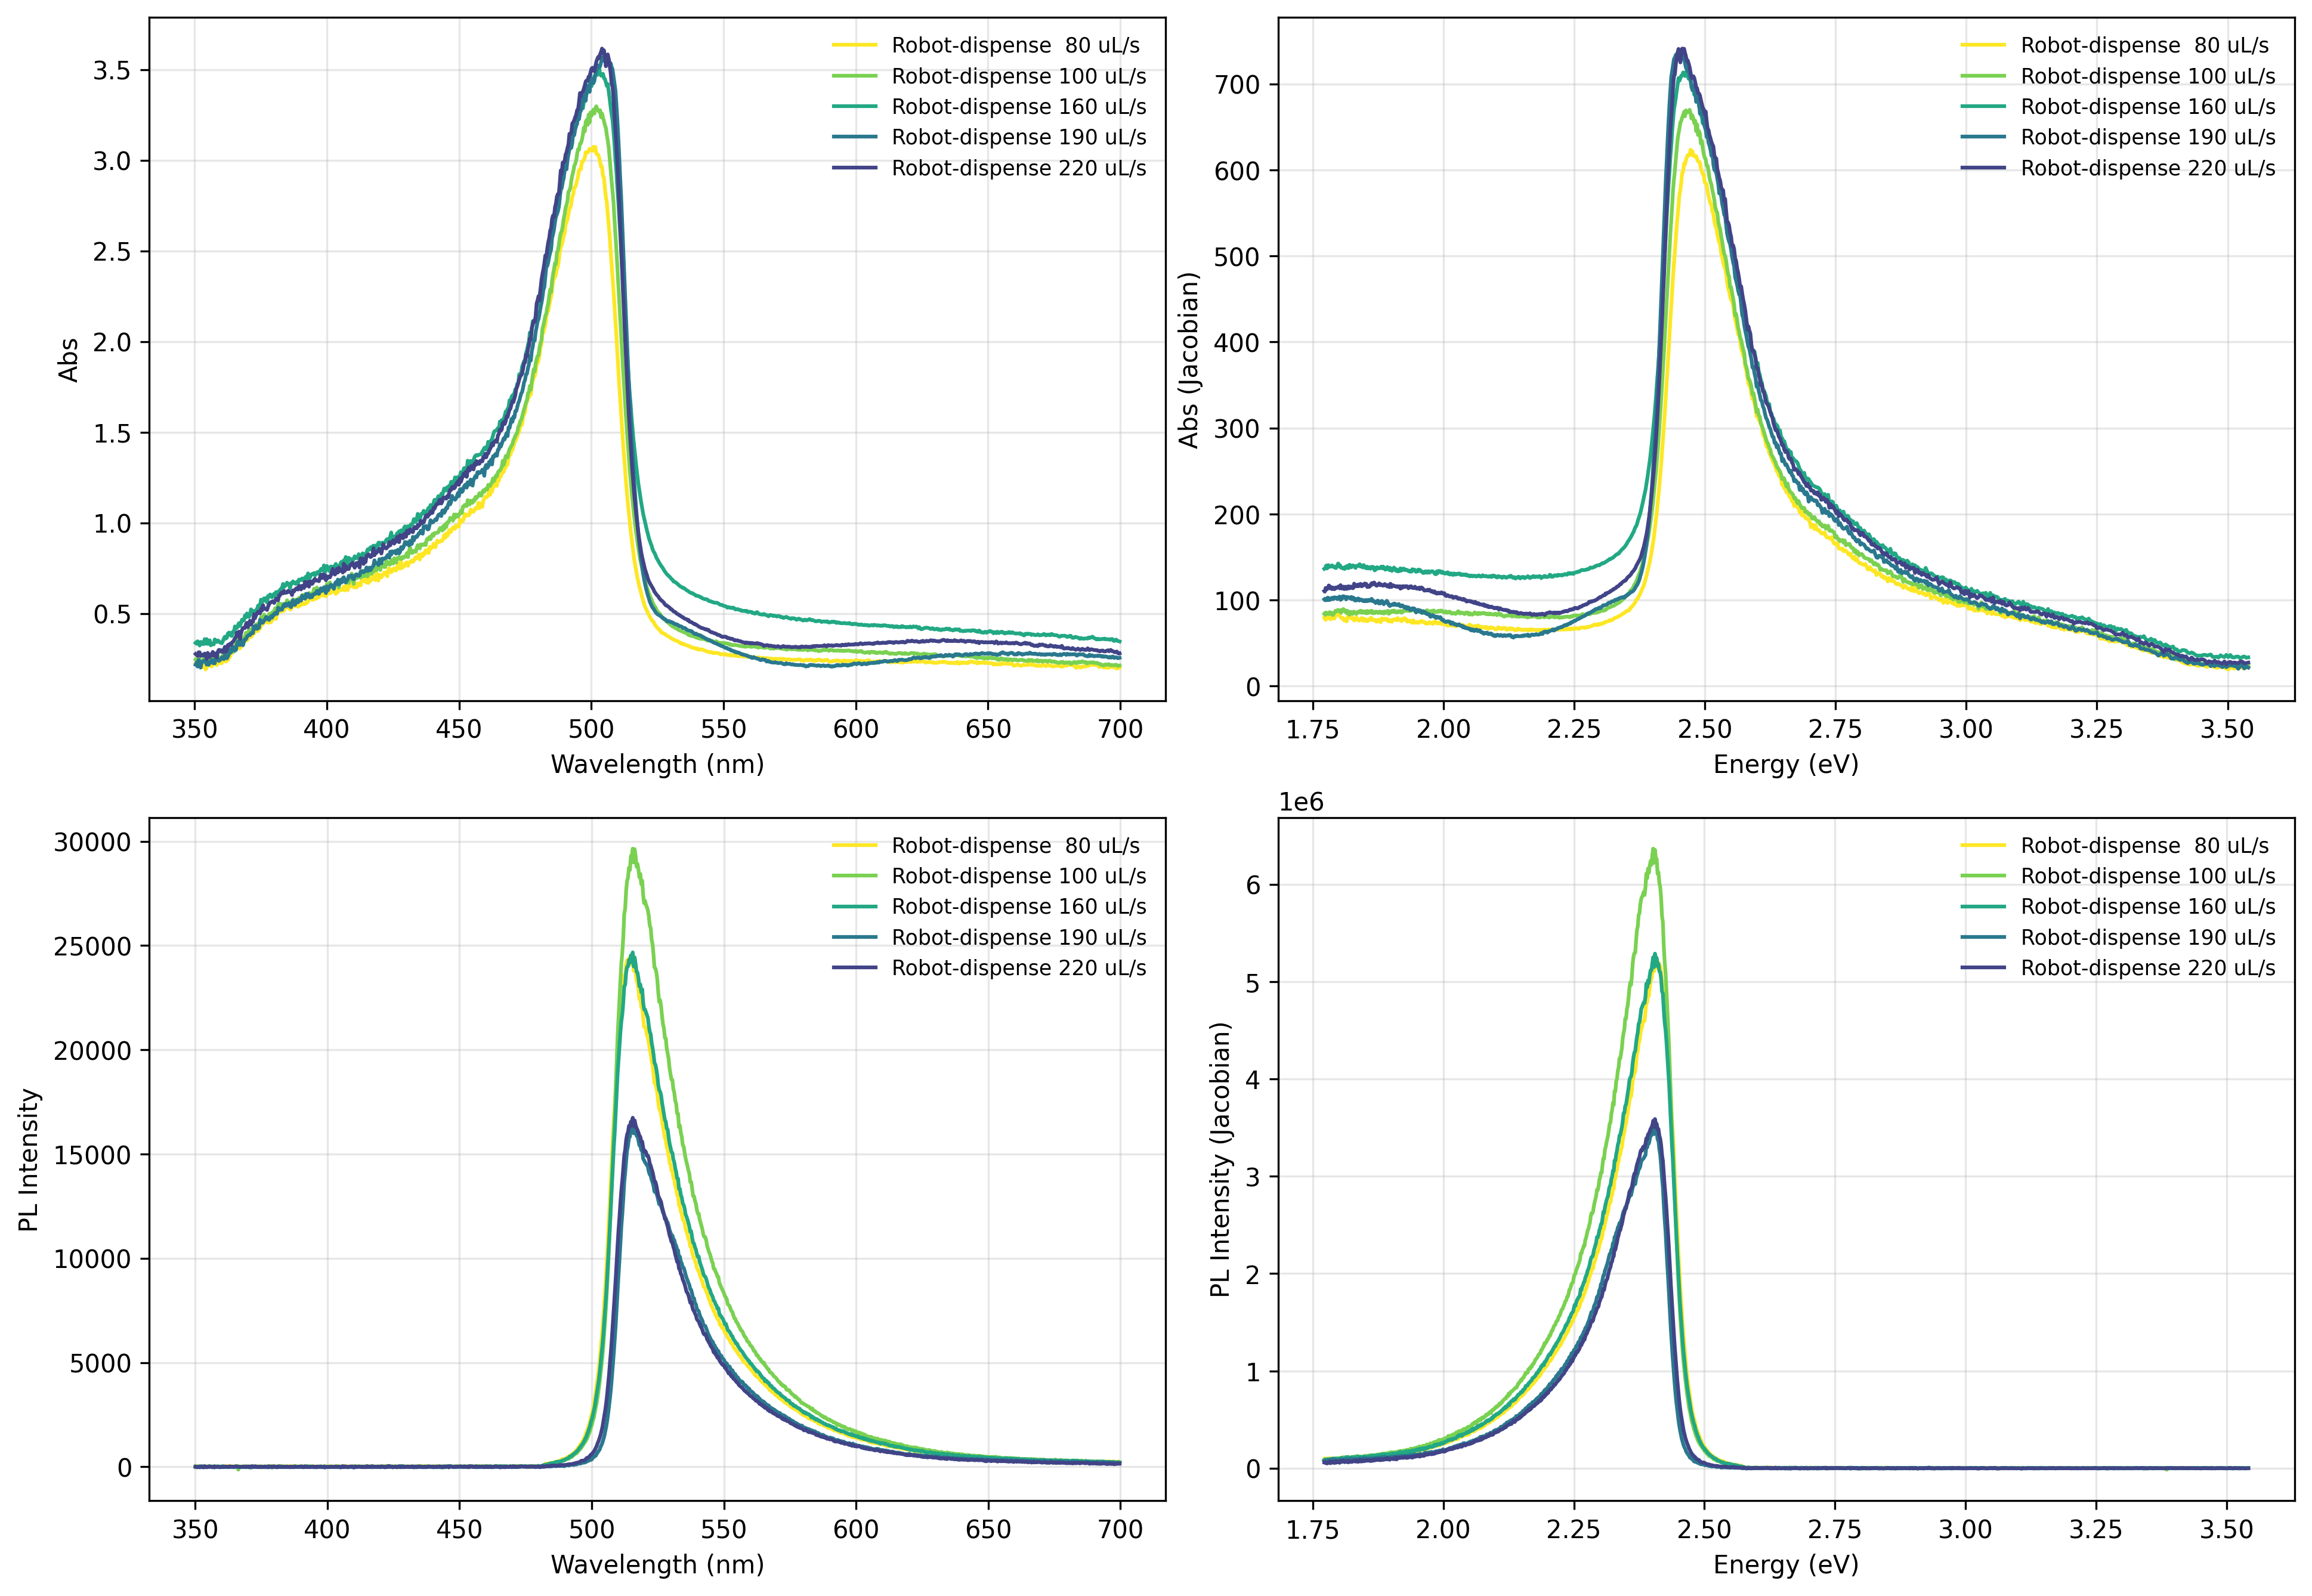

In [12]:
# Set up color cycle similar to cd-plot

output_file = Path(data_dirs[0], "20250721_S_MeOMBAI_prestudy_3_dispense.jpg")

for dfs in [uv_vis_dfs, pl_dfs]:
    index_to_remove = []
    for i, df in enumerate(dfs):
        # if "MBAI" not in df["metadata"][0]["label"]:
        #     index_to_remove.append(i)
        # if 'MBAI' in df['metadata'][0]['label']:
        #     index_to_remove.append(i)
        if "dispense" not in df["metadata"][0]["label"]:
            index_to_remove.append(i)
    for i in sorted(index_to_remove, reverse=True):
        del dfs[i]

from plot_helper import get_color_factory

# Initialize styling functions
# get_linestyle_func = get_linestyle_factory
get_linestyle_func = lambda: lambda label: None

get_color_func = lambda: get_color_factory(
    colormap="sequential",
    cycle_by_prefix=False,
)

# Create main plotting figure with 2x2 subplots
fig, ((ax_uv_abs_wl, ax_uv_abs_energy), (ax_pl_int_wl, ax_pl_int_energy)) = (
    plt.subplots(nrows=2, ncols=2, figsize=(13, 9), dpi=300)
)

# Plot 1 - UV-Vis Results: Absorption vs Wavelength and Absorption (Jacobian) vs Energy
# UV-Vis Absorption vs Wavelength
plot_single_column_data(
    ax_uv_abs_wl,
    uv_vis_dfs,
    "wavelength",
    "absorption",
    xlabel="Wavelength (nm)",
    ylabel="Abs",
    # lw=0.8,
    get_linestyle_func=get_linestyle_func(),
    get_color_func=get_color_func(),
)
# ax_uv_abs_wl.set_title("UV-Vis Absorption vs Wavelength")

# UV-Vis Absorption (Jacobian) vs Energy
plot_single_column_data(
    ax_uv_abs_energy,
    uv_vis_dfs,
    "energy",
    "absorption_jacobian",
    xlabel="Energy (eV)",
    ylabel="Abs (Jacobian)",
    # lw=0.8,
    get_linestyle_func=get_linestyle_func(),
    get_color_func=get_color_func(),
)
# ax_uv_abs_energy.set_title("UV-Vis Absorption (Jacobian) vs Energy")

# Plot 2 - PL Results: Intensity vs Wavelength and Intensity (Jacobian) vs Energy
# PL Intensity vs Wavelength
plot_single_column_data(
    ax_pl_int_wl,
    pl_dfs,
    "wavelength",
    "intensity",
    xlabel="Wavelength (nm)",
    ylabel="PL Intensity",
    # lw=0.8,
    get_linestyle_func=get_linestyle_func(),
    get_color_func=get_color_func(),
)
# ax_pl_int_wl.set_title("PL Intensity vs Wavelength")

# PL Intensity (Jacobian) vs Energy
plot_single_column_data(
    ax_pl_int_energy,
    pl_dfs,
    "energy",
    "intensity_jacobian",
    xlabel="Energy (eV)",
    ylabel="PL Intensity (Jacobian)",
    # lw=0.8,
    get_linestyle_func=get_linestyle_func(),
    get_color_func=get_color_func(),
)
# ax_pl_int_energy.set_title("PL Intensity (Jacobian) vs Energy")

# Final layout and save
fig.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)

# Save the plot
if len(h5_files) > 0:
    fig.savefig(output_file, dpi=300, bbox_inches="tight")
    print(f"Plot saved to: {output_file}")

plt.show()

In [ ]:
# Create n×3 plot of all adj_photo images
def plot_adj_photo_images(h5_files, data_dirs, normalize=False, colormap="gist_gray"):
    """Plot all adj_photo images in an n×3 grid layout."""

    # Collect all adj_photo images and their metadata
    images_data = []

    for i, h5_file in enumerate(h5_files):
        print(
            f"Reading adj_photo from file {i + 1}/{len(h5_files)}: {Path(h5_file).name}"
        )

        # Read the H5 file
        data = read_h5_file(h5_file)
        if data is None:
            continue

        # Extract adj_photo image
        adj_photo = data["photo"]["adj_photo"]
        if adj_photo is not None and adj_photo.size > 0:
            label = get_label(data["metadata"])
            images_data.append(
                {
                    "image": np.array(adj_photo),
                    "exporsure": data["photo"]["adj_photo_exposure"],
                    "label": label,
                    "sample_id": data["metadata"]["sample_id"],
                    "file_name": Path(h5_file).name,
                }
            )

    if not images_data:
        print("No adj_photo images found!")
        return

    # Get the brightest pixels among all noremalized adj_photo images
    if normalize:
        max_normalized_intensity = max(
            [
                img_data["image"].max() / img_data["exporsure"]
                for img_data in images_data
            ]
        )

    # Calculate grid dimensions (n rows × 3 columns)
    n_images = len(images_data)
    n_cols = 3
    n_rows = (n_images + n_cols - 1) // n_cols  # Ceiling division

    # Create the plot
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(15, 5 * n_rows), dpi=600, layout="constrained"
    )

    # Handle case where there's only one row
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)

    # Plot images
    for i, img_data in enumerate(sorted(images_data, key=lambda x: x["label"])):
        row = i // n_cols
        col = i % n_cols

        ax = axes[row, col]

        # Trim the image to a square
        img_dim = img_data["image"].shape
        x_offset = 500

        img = img_data["image"][:, x_offset : (img_dim[0] + x_offset)]

        if normalize:
            img = (img / img_data["exporsure"]) / max_normalized_intensity

        # Display the image
        # Assuming adj_photo is a 2D grayscale image
        im = ax.imshow(img, cmap="gist_gray", aspect="equal")
        ax.set_title(f"{img_data['label']}")
        ax.axis("off")

        # Add colorbar
        if row != (i - 1) // n_cols:
            fig.colorbar(im, ax=axes[row, :], pad=0.01)

    # Hide empty subplots
    for i in range(n_images, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].axis("off")

    # Save the plot
    output_file = Path(
        data_dirs[0],
        f"adj_photo_grid_{n_images}_samples_{colormap}{'_normalized' if normalize else ''}.jpg",
    )
    fig.savefig(output_file, dpi=300, bbox_inches="tight")
    print(f"adj_photo grid plot saved to: {output_file}")

    plt.show()

    return images_data


# Call the function to create the plot
images_data = plot_adj_photo_images(h5_files, data_dirs)
images_data = plot_adj_photo_images(h5_files, data_dirs, normalize=True)

print("Completed processing and plotting all data.")